In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import RegularGridInterpolator, splrep, splev
import numpy as np
import pickle
from matplotlib import pyplot as plt
import numpy.ma as ma
# from settings import *

In [3]:
import warnings
from copy import deepcopy
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2, norm
from matplotlib.colors import LogNorm
warnings.filterwarnings("ignore")
import csv
from scipy.interpolate import InterpolatedUnivariateSpline

# Ple$\nu$m calculation

### local coordinates

In [4]:
coords = {
    'IceCube': {"lon": 0*u.deg, "lat": -90*u.deg},
    'P-ONE': {"lon": -123.3656*u.deg, "lat": 48.4284*u.deg},
    'KM3NeT': {"lon": (16 + 6/60)*u.deg, "lat": (36 + 16/60)*u.deg},
    'Baikal-GVD': {"lon": 108.1650*u.deg, "lat": 53.5587*u.deg}
}

In [5]:
'''coords_grand = {
    'Grand_1': {"lon": 10*u.deg, "lat": 60*u.deg},
    'Grand_2': {"lon": -115*u.deg, "lat": 49*u.deg},
    'Grand_3': {"lon": -5*u.deg, "lat": 38*u.deg},
    'Grand_4': {"lon": -10*u.deg, "lat": 27*u.deg},
    'Grand_5': {"lon": -13.5*u.deg, "lat": 16*u.deg},
    'Grand_6': {"lon": -70*u.deg, "lat": 5*u.deg},
    'Grand_7': {"lon": -41*u.deg, "lat": -4.4*u.deg},
    'Grand_8': {"lon": -70*u.deg, "lat": -16*u.deg},
    'Grand_9': {"lon": -70*u.deg, "lat": -27*u.deg},
    'Grand_10': {"lon": -71*u.deg, "lat": -40*u.deg},
    'NP': {"lon": 0*u.deg, "lat": 90*u.deg},
    'EQ': {"lon": 0*u.deg, "lat": 0*u.deg}
}'''

'coords_grand = {\n    \'Grand_1\': {"lon": 10*u.deg, "lat": 60*u.deg},\n    \'Grand_2\': {"lon": -115*u.deg, "lat": 49*u.deg},\n    \'Grand_3\': {"lon": -5*u.deg, "lat": 38*u.deg},\n    \'Grand_4\': {"lon": -10*u.deg, "lat": 27*u.deg},\n    \'Grand_5\': {"lon": -13.5*u.deg, "lat": 16*u.deg},\n    \'Grand_6\': {"lon": -70*u.deg, "lat": 5*u.deg},\n    \'Grand_7\': {"lon": -41*u.deg, "lat": -4.4*u.deg},\n    \'Grand_8\': {"lon": -70*u.deg, "lat": -16*u.deg},\n    \'Grand_9\': {"lon": -70*u.deg, "lat": -27*u.deg},\n    \'Grand_10\': {"lon": -71*u.deg, "lat": -40*u.deg},\n    \'NP\': {"lon": 0*u.deg, "lat": 90*u.deg},\n    \'EQ\': {"lon": 0*u.deg, "lat": 0*u.deg}\n}'

In [34]:
coords_grand = {
    'GRAND_1': {"lon": 10*u.deg, "lat": 60*u.deg},
    'GRAND_2': {"lon": -130*u.deg, "lat": 57.2*u.deg},
    'GRAND_3': {"lon": -115*u.deg, "lat": 49*u.deg},
    'GRAND_4': {"lon": -110*u.deg, "lat": 44*u.deg},
    'GRAND_5': {"lon": -5*u.deg, "lat": 38*u.deg},
    'GRAND_6': {"lon": -100*u.deg, "lat": 33*u.deg},
    'GRAND_7': {"lon": -10*u.deg, "lat": 27*u.deg},
    'GRAND_8': {"lon": -100*u.deg, "lat": 21*u.deg},
    'GRAND_9': {"lon": -13.5*u.deg, "lat": 16*u.deg},
    'GRAND_10': {"lon": 104*u.deg, "lat": 11*u.deg},
    'GRAND_11': {"lon": -70*u.deg, "lat": 5*u.deg},
    'GRAND_12': {"lon": 113*u.deg, "lat": 0*u.deg},
    'GRAND_13': {"lon": -41*u.deg, "lat": -4.4*u.deg},
    'GRAND_14': {"lon": 149*u.deg, "lat": -10*u.deg},
    'GRAND_15': {"lon": -70*u.deg, "lat": -16*u.deg},
    'GRAND_16': {"lon": 149*u.deg, "lat": -21*u.deg},
    'GRAND_17': {"lon": -70*u.deg, "lat": -27*u.deg},
    'GRAND_18': {"lon": 152*u.deg, "lat": -30*u.deg},
    'GRAND_19': {"lon": 150*u.deg, "lat": -35*u.deg},
    'GRAND_20': {"lon": -71*u.deg, "lat": -40*u.deg},
    'NP': {"lon": 0*u.deg, "lat": 90*u.deg},
    'EQ': {"lon": 0*u.deg, "lat": 0*u.deg}
}

# Get the detection efficiency from the public mc table

**Effective area Code from analysis code**

In [35]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [36]:
def energy_smearing(ematrix, ev):
    """Translate a matrix with axis in log10(true energy) to log10(reconstructed energy)"""
    return (ematrix @ ev.T).T

In [37]:
def flux_to_events(aeff_factor, flux_vals):
    """Calculate the number of neutrinos of an arbitrary flux 
    as a function reconstructed energy. If aeff_factor is 2D, eg. in sin(dec) and log(E_true),
    the result will also be 2D, in sin(dec) and log(E_reco) then. """
    return energy_smearing(normed_kvals, aeff_factor * flux_vals)

In [38]:
# use only upgoing data to mimick up-going muon track data set
with open("resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins, sindec_bins, aeff_2d = pickle.load(f)

# get the mids of the log(true energy / GeV) binning
logE_mids = get_mids(logE_bins)
# cut all arrays at E=10⁹GeV
logE_bins = logE_bins[logE_bins<=11]
# for this demo, we only look at IceCube's effective area
aeff_2d = aeff_2d["IceCube"][logE_mids<=11]
logE_mids = logE_mids[logE_mids<=11]

# get the binning also in true energy
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

# same for sin(dec) binning
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")



40 log_10(energy) bins
50 declination bins


[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


(2.0, 9.0)

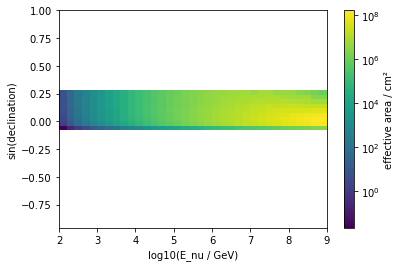

In [39]:
#CREATE MASK AND PLOT OF AEFF

# get mids
#sindec_binsmids = get_mids(sindec_bins)
sindec_bins = np.delete(sindec_bins, 0)

# create sindec_bins mask
masked_sindec = ma.masked_where(sindec_bins >= 0.25 , sindec_bins, copy=True)

# horizontally repeat sindec_bins mask to fit aeff array
stacked_mask = masked_sindec.mask
for i in range(len(aeff_2d.T[0])-1):
    stacked_mask = np.column_stack((stacked_mask, masked_sindec.mask))
                
# apply stacked_mask mask to aeff
masked_aeff2d = ma.masked_array(aeff_2d.T, mask = stacked_mask)
print(masked_aeff2d)


# plot the effective area (only up-going events)
plt.pcolormesh(logE_bins, sindec_bins, masked_aeff2d , norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 9)

In [40]:
# PLOT FIGURE 25

'''# BLUE LINE
# csv: convert in float
energy = []
aeff = []
with open('resources/figure25blauelineaxen.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=';', quotechar='|', skipinitialspace=True)
    for row in reader:
        energy.append(float(row[0].replace(",", ".")))
        aeff.append(float(row[1].replace(",", ".")))

plt.plot(energy, aeff, marker="o", label="Simulated effective area of GRAND200k HotSpot1")
plt.loglog()
plt.xlabel("Neutrino energy $E_\mu [GeV]$")
plt.ylabel("Direction-averaged effective area $ \langle A_{eff}  (E_\mu) \langle[cm^2]$" )
plt.legend()
plt.title("Figure 25")'''

'# BLUE LINE\n# csv: convert in float\nenergy = []\naeff = []\nwith open(\'resources/figure25blauelineaxen.csv\', newline=\'\') as csvfile:\n    reader = csv.reader(csvfile, delimiter=\';\', quotechar=\'|\', skipinitialspace=True)\n    for row in reader:\n        energy.append(float(row[0].replace(",", ".")))\n        aeff.append(float(row[1].replace(",", ".")))\n\nplt.plot(energy, aeff, marker="o", label="Simulated effective area of GRAND200k HotSpot1")\nplt.loglog()\nplt.xlabel("Neutrino energy $E_\\mu [GeV]$")\nplt.ylabel("Direction-averaged effective area $ \\langle A_{eff}  (E_\\mu) \\langle[cm^2]$" )\nplt.legend()\nplt.title("Figure 25")'

Text(0.5, 1.0, 'Figure 25')

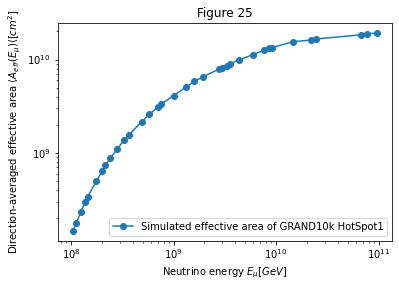

In [41]:
# PLOT FIGURE 25

# ORANGE LINE
# csv: convert in float
energy = []
aeff = []
with open('resources/figure25_35datapoints.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=';', quotechar='|', skipinitialspace=True)
    for row in reader:
        energy.append(float(row[0].replace(",", ".")))
        aeff.append(float(row[1].replace(",", ".")))

plt.plot(energy, aeff, marker="o", label="Simulated effective area of GRAND10k HotSpot1")
plt.loglog()
plt.xlabel("Neutrino energy $E_\mu [GeV]$")
plt.ylabel("Direction-averaged effective area $ \langle A_{eff}  (E_\mu) \langle[cm^2]$" )
plt.legend()
plt.title("Figure 25")

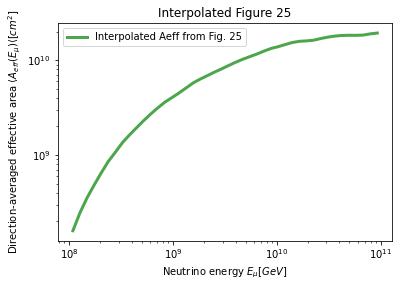

In [42]:
#GET SPL AEFF

#get new_logE_bins
new_logE_bins = np.linspace(8, 11, 45) 
new_ebins = np.power(10, new_logE_bins)
new_logE_mids = get_mids(new_logE_bins)
new_emids = get_mids(new_ebins) 
new_ewidth = np.diff(new_ebins)

#create interpolated aeff from fig. 25
spl = InterpolatedUnivariateSpline(energy, aeff)
new_spl_aeff = spl(new_emids)

#Plot interpolated aeff from fig. 25
plt.plot(new_emids, new_spl_aeff, 'g', lw=3, alpha=0.7, label="Interpolated Aeff from Fig. 25" )
plt.loglog()
plt.xlabel("Neutrino energy $E_\mu [GeV]$")
plt.ylabel("Direction-averaged effective area $ \langle A_{eff}  (E_\mu) \langle[cm^2]$" )
plt.title("Interpolated Figure 25")
plt.legend()

(-1.0, 1.0)

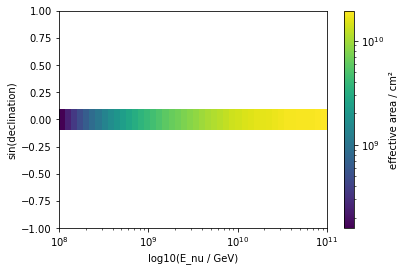

In [43]:
#CREATE 3D PLOT WITH INTERPOLATED AEFF FROM FIG. 25

#create arrays
single_sindecbin = np.array([-0.1,0.1])
spl_aeff_3d = np.array([new_spl_aeff,new_spl_aeff,])
new_sindec_width = np.diff(single_sindecbin)


#plot 3D interpolated aeff from fig. 25
plt.pcolormesh(new_ebins, single_sindecbin, spl_aeff_3d , norm=LogNorm())
cb = plt.colorbar()
plt.xscale("log")
cb.set_label("effective area / cm²")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.ylim(-1, 1)

In [44]:
import numpy as np

In [45]:
'''z1 = np.sin(np.deg2rad(-5))
z2 = np.sin(np.deg2rad(5))
np.where((sindec_bins >= z1) & (sindec_bins <= z2))'''

'z1 = np.sin(np.deg2rad(-5))\nz2 = np.sin(np.deg2rad(5))\nnp.where((sindec_bins >= z1) & (sindec_bins <= z2))'

[23 24 25]


Text(0.5, 0, 'log10(E_nu / GeV)')

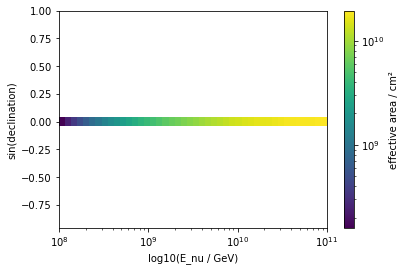

In [46]:
z1 = np.sin(np.deg2rad(-2.3))
z2 = np.sin(np.deg2rad(2.3))
bin_selection = np.where((sindec_bins>=z1) & (sindec_bins<=z2))[0]
print(bin_selection)
# new
new_aeff = np.zeros((len(new_emids), len(sindec_bins)))
for i in bin_selection[:-1]: 
    new_aeff[:,i] = new_spl_aeff

plt.pcolormesh(new_ebins, sindec_bins, new_aeff.T , norm=LogNorm())
cb = plt.colorbar()
plt.xscale("log")
cb.set_label("effective area / cm²")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")

In [47]:
'''# new
new_aeff = np.zeros((len(new_emids), len(sindec_width)))
for i in range(22, 26): ### UHECRs 27-34
    new_aeff[:,i] = new_spl_aeff

plt.pcolormesh(new_ebins, sindec_bins, new_aeff.T , norm=LogNorm())


cb = plt.colorbar()
plt.xscale("log")
cb.set_label("effective area / cm²")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
#plt.ylim(-1, 1)

np.shape(new_aeff)'''

'# new\nnew_aeff = np.zeros((len(new_emids), len(sindec_width)))\nfor i in range(22, 26): ### UHECRs 27-34\n    new_aeff[:,i] = new_spl_aeff\n\nplt.pcolormesh(new_ebins, sindec_bins, new_aeff.T , norm=LogNorm())\n\n\ncb = plt.colorbar()\nplt.xscale("log")\ncb.set_label("effective area / cm²")\nplt.ylabel("sin(declination)")\nplt.xlabel("log10(E_nu / GeV)")\n#plt.ylim(-1, 1)\n\nnp.shape(new_aeff)'

In [48]:
#SAFE THE AEFF DATA 

basepath = "/Users/alexandraschroder/Bachelorarbeit/Notebook/"
from os.path import join

with open(join(basepath, "resources/new_aeff.pckl"), "wb") as a:
    pickle.dump((new_aeff, new_ebins, new_emids, sindec_mids, sindec_bins, new_ewidth), a)

**Get the effective area**

In [49]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [50]:
import pickle
import numpy as np

from scipy.interpolate import InterpolatedUnivariateSpline
basepath = "/Users/alexandraschroder/Bachelorarbeit/Notebook/"
from os.path import join

with open(join(basepath, "resources/new_aeff.pckl"), "rb") as a:
     new_aeff, new_ebins, new_emids, sindec_mids, sindec_bins, new_ewidth = pickle.load(a)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = get_mids(ra_bins)
ra_width = ra_bins[1:] - ra_bins[:-1]

## Idea: transform the integration over R.A. per sin(dec) into local coordinates

**Note:** here, equal contributions of each detector are assumed. In case one wants to use different livetimes, the effective areas have to multiplied individually before calculating e.g. the expected number of astrophysical events

In [55]:
# Interpolated grid of the effective area in "local" coordinates
# (= icecube's native coordinates)
grid2d = [RegularGridInterpolator(
    (np.arcsin(sindec_mids), ra_mids), # transform dec to local theta
    # switch back to local zenith, add ra as new axis and normalize accordingly
    new_aeff[i][::-1,np.newaxis] / np.atleast_2d(ra_width)/ len(ra_mids), ### deine effective A.
    method='linear',
    bounds_error=False,
    fill_value=0.
) for i in range(len(new_emids))]
# grid elements are calculated for each energy bin, grid is theta x phi

# coordinate grid in equatorial coordinates (icrs)
# these will be the integration coordinates
pp, tt = np.meshgrid(ra_mids, np.arcsin(sindec_mids))
eq_coords_grand = SkyCoord(
    pp * u.radian,
    tt * u.radian,
    frame="icrs"
)

aeff_i = {}
factor = 10 # for plotting energy slices
aeff_i["GRAND200k"] = np.zeros_like(new_aeff) # deine aeff

# loop over detectors
for k, coord in coords_grand.items():
    print(k)
    # local detector
    loc = EarthLocation(
        lat=coord["lat"],
        lon=coord["lon"],
    )
    # arbitrary time, doesnt matter here
    time = Time('2021-6-21 00:00:00')
    # transform integration coordinates to local frame
    local_coords_grand = eq_coords_grand.transform_to(AltAz(obstime=time, location=loc))
    # sum up the contributions over the transformed RA axis per declination 
    
    # loop over the energy bins to get the same shape of aeff as before
    # sum along transformed ra coordinates
    aeff_i[k] = np.array([np.sum(
        grid2d[i]((local_coords_grand.alt.rad, local_coords_grand.az.rad)) * ra_width, # integrate over RA
        axis=1) for i in range(len(new_emids))])
    
    if not "GRAND" in k: continue

    aeff_i["GRAND200k"] += aeff_i[k]

GRAND_1
GRAND_2
GRAND_3
GRAND_4
GRAND_5
GRAND_6
GRAND_7
GRAND_8
GRAND_9
GRAND_10
GRAND_11
GRAND_12
GRAND_13
GRAND_14
GRAND_15
GRAND_16
GRAND_17
GRAND_18
GRAND_19
GRAND_20
NP
EQ


## save to disc

In [56]:
#with open("resources/tabulated_logE_sindec_aeff_GRAND.pckl", "wb") as f:
#    pickle.dump((np.log10(new_ebins), sindec_bins, aeff_i), f)
    
with open("resources/tabulated_logE_sindec_aeff_GRAND.pckl", "wb") as f:
    pickle.dump((new_ebins, sindec_bins, aeff_i), f)    

## effective area checking plots

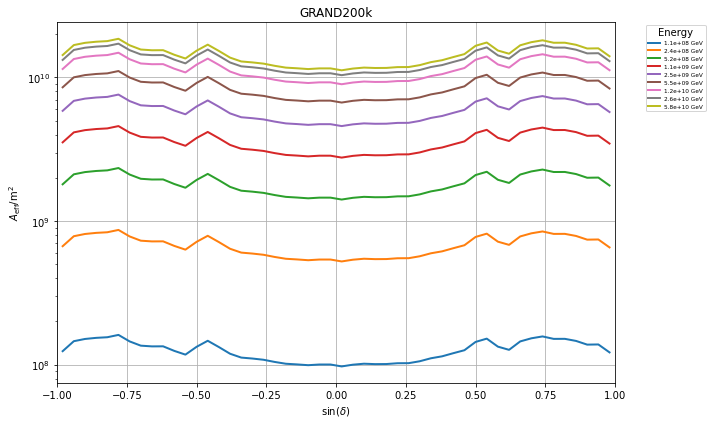

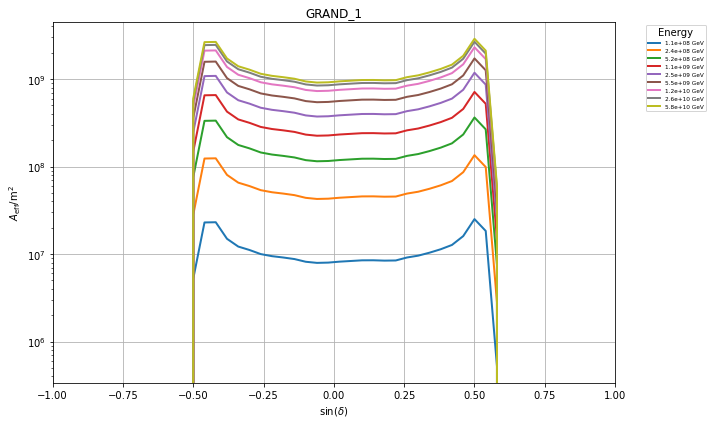

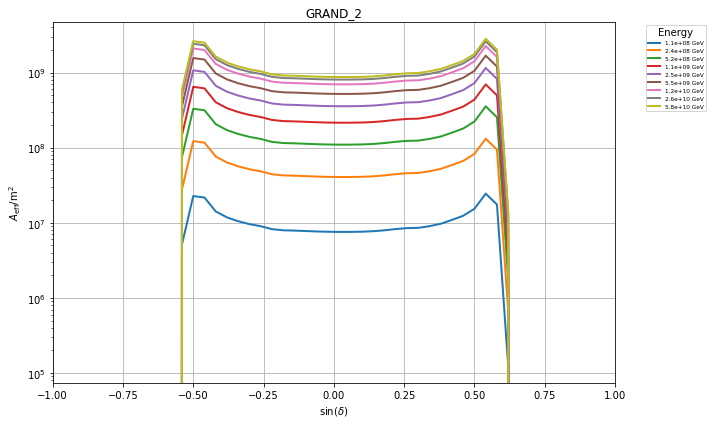

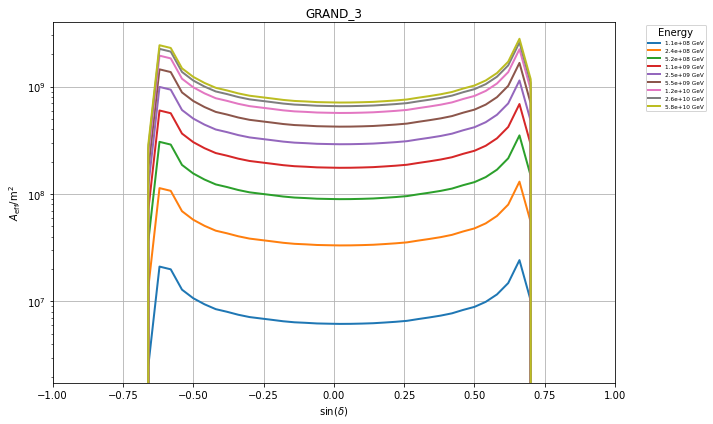

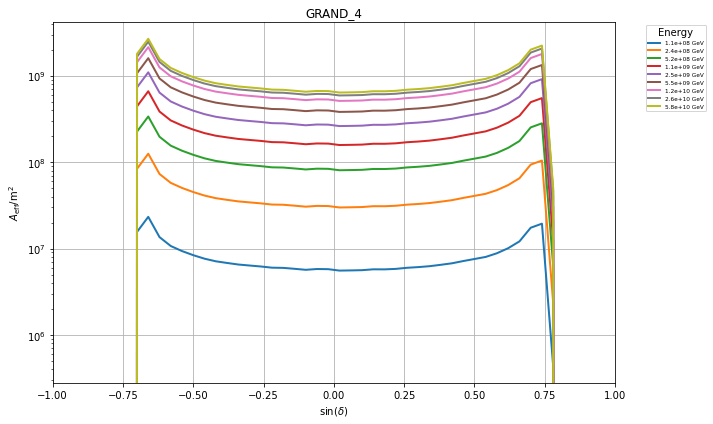

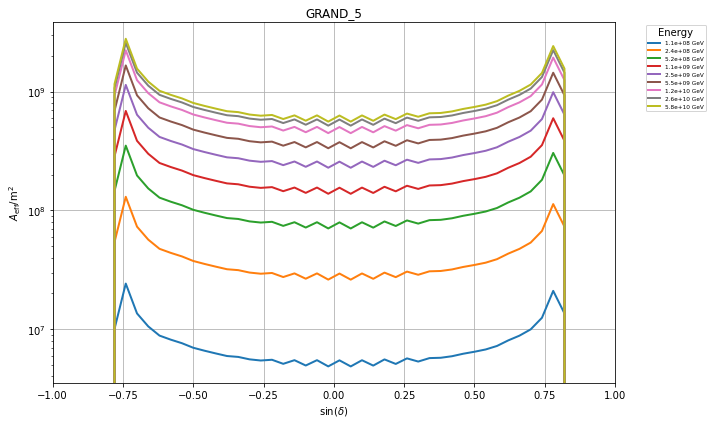

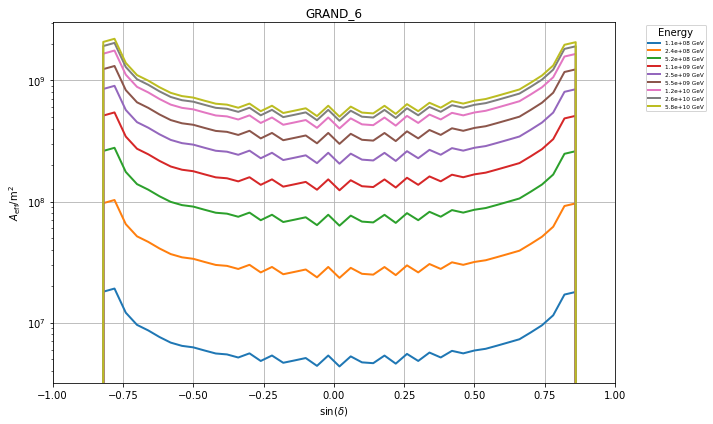

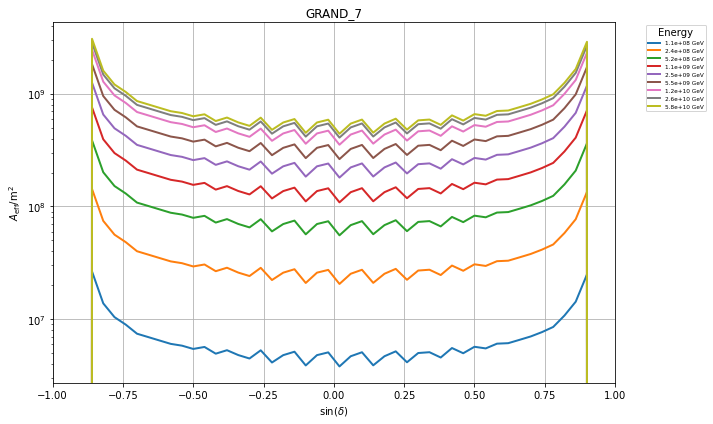

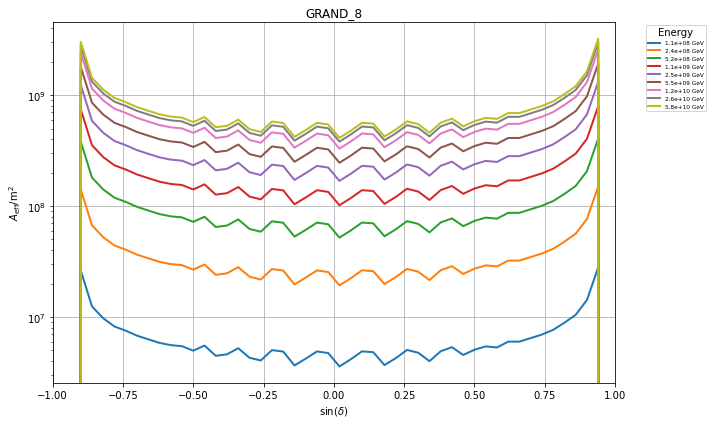

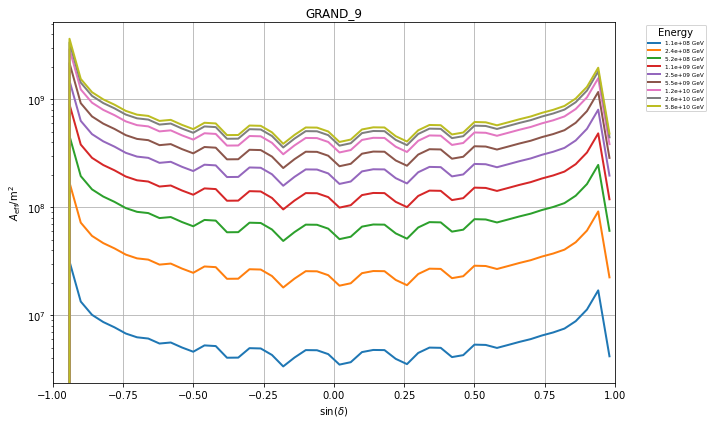

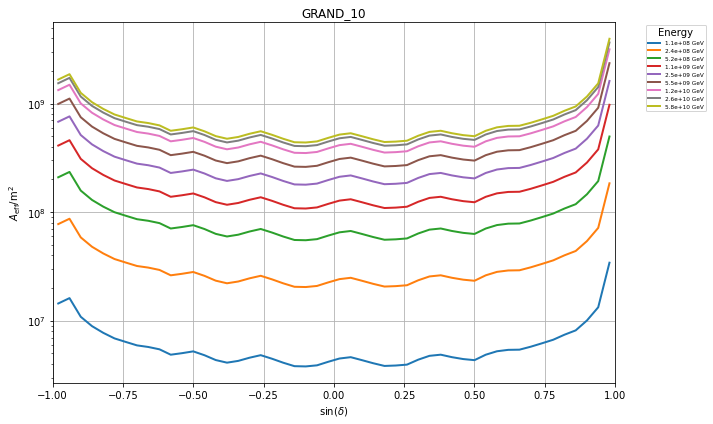

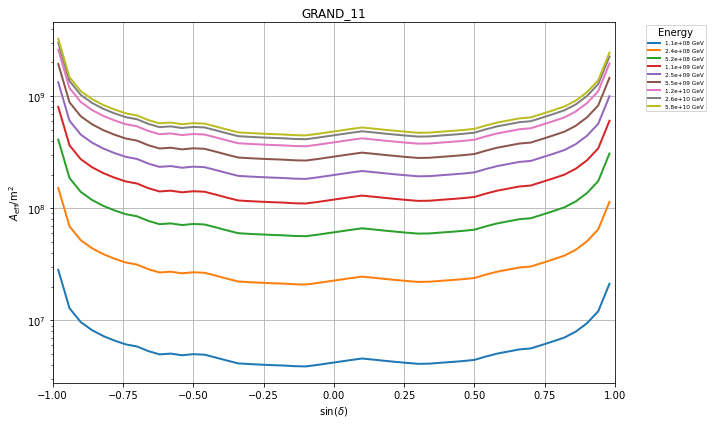

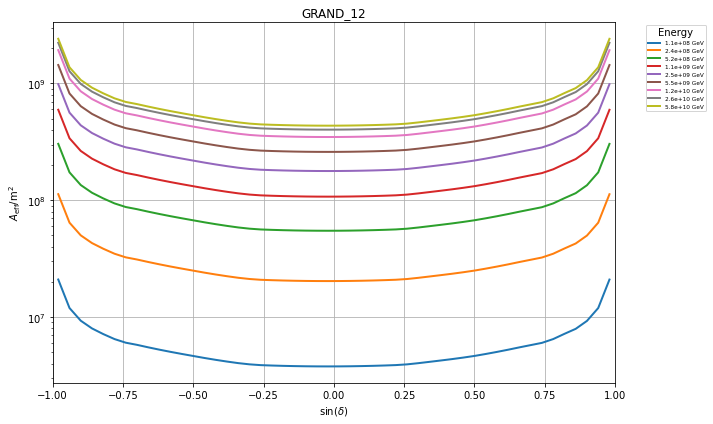

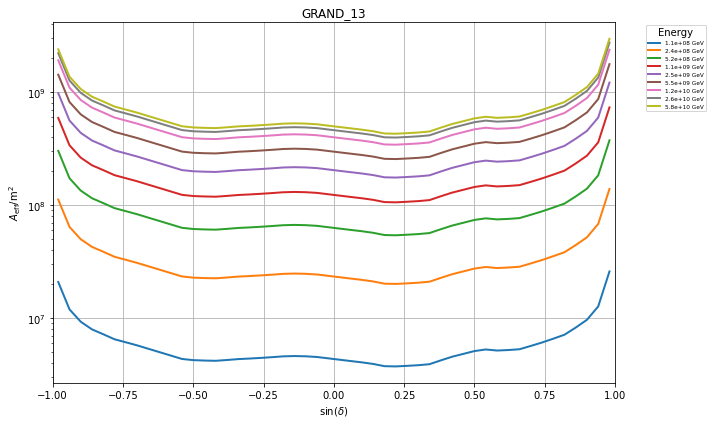

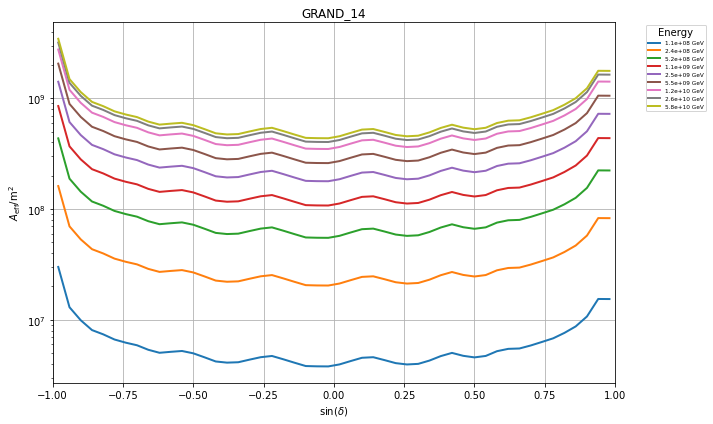

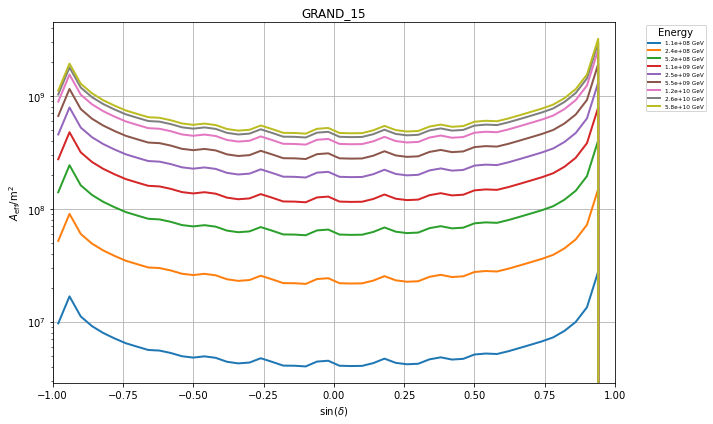

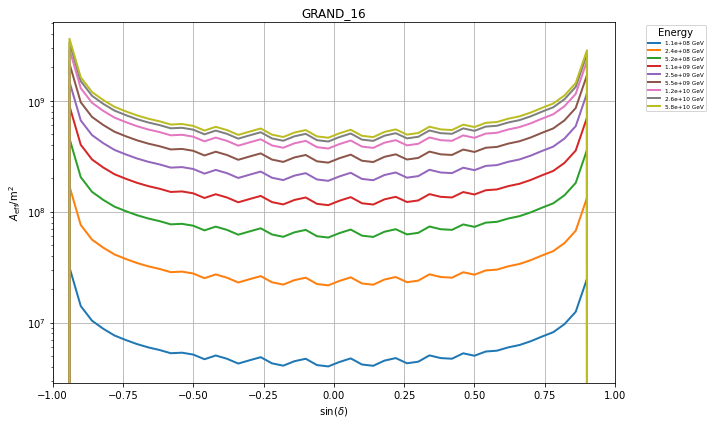

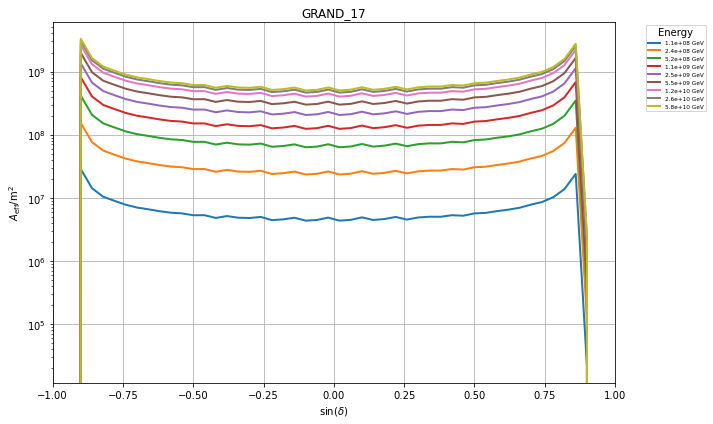

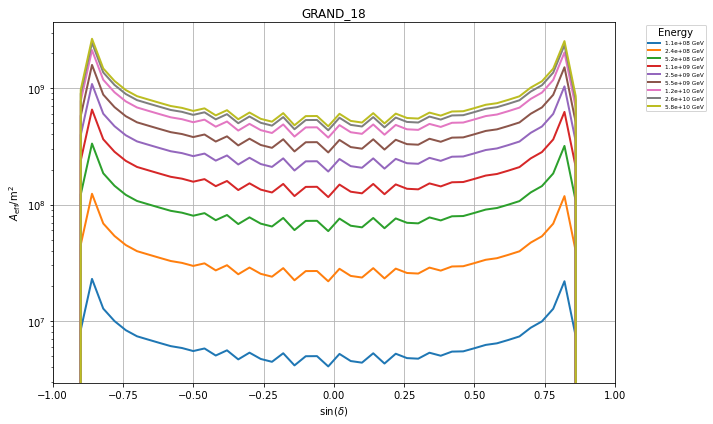

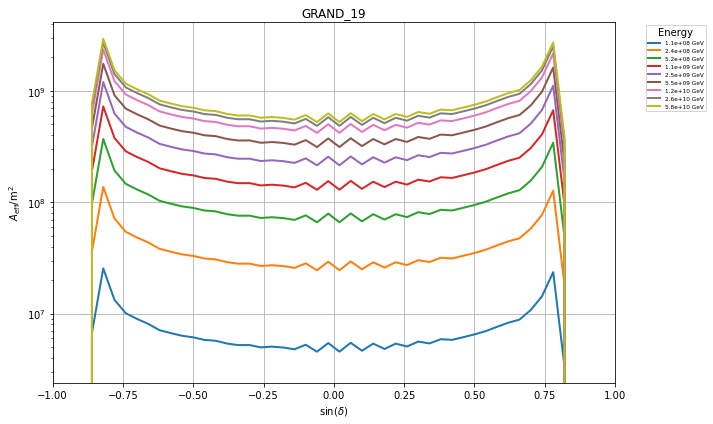

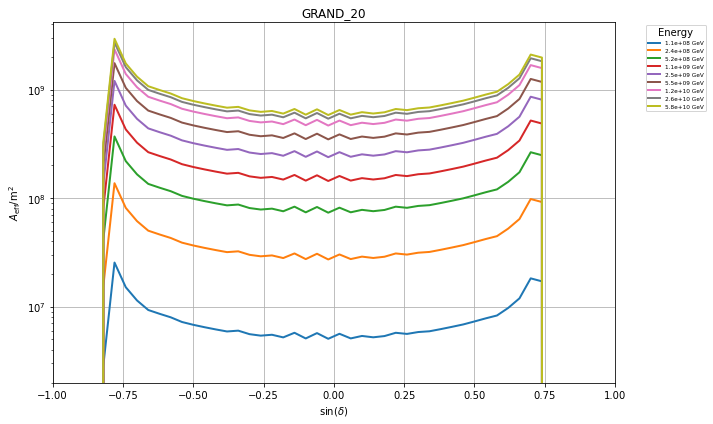

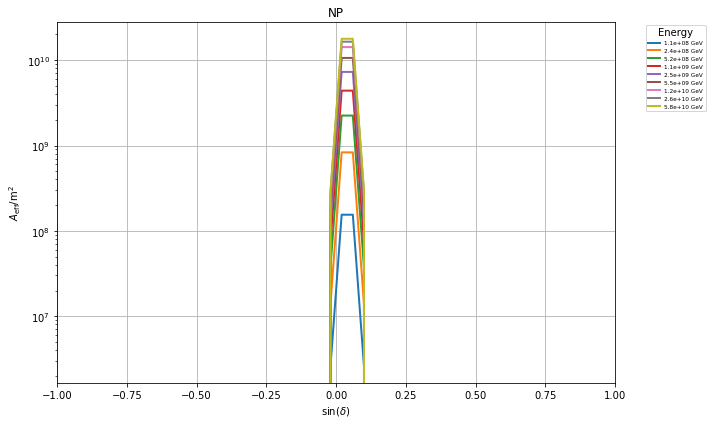

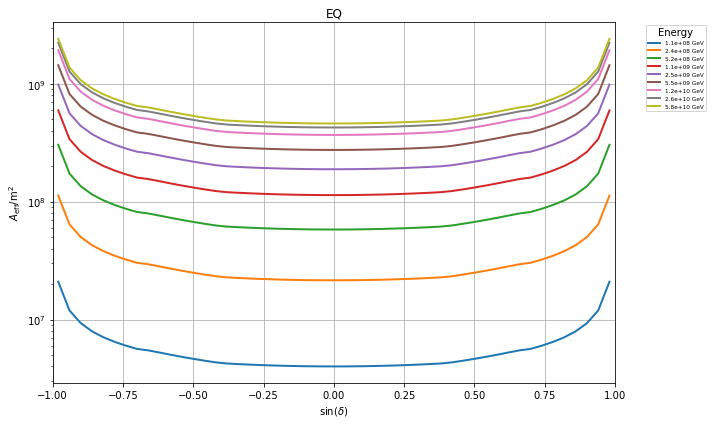

In [57]:
factor = 5
nlines = len(new_emids) // factor + 1
mid_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][nlines // 2]
for k in aeff_i:
    plt.figure(figsize=(10, 6))
    for ie, ae in enumerate(aeff_i[k][::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{new_emids[ie*factor]:1.1e} GeV",
            ls="-", # rotated
            lw=2
        )
        if k=="IceCube":
            plt.plot(
                sindec_mids, new_aeff[ie*factor],
                ls=":", # original
                color=slightly_change_color(line[0].get_color(), amount=0.2),
                lw=2
            )

    plt.yscale("log")
    plt.title(k)
    if k=="IceCube":
        lines = [
            matplotlib.lines.Line2D(
                [0],
                [0],
                color=slightly_change_color(mid_color),
                linestyle=":"
            ),
            matplotlib.lines.Line2D(
                [0],
                [0],
                color=mid_color,
                linestyle="-")
        ]
        labels = ['original', 'rotated']
        lg = plt.legend(lines, labels, title="Cross check")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Energy", fontsize="xx-small")
    if k=="IceCube":
        ax = plt.gca()
        ax.add_artist(lg)                
    plt.grid(True)
    plt.xlim(-1, 1)
    #plt.ylim(10, 3E8)
    plt.xlabel(r"$\sin(\delta)$")
    plt.ylabel(r"$A_{\rm eff}/ {\rm m}^2$")
    plt.tight_layout()
    #plt.savefig(f"../plots/{k}_alt_aeff.pdf")


## 2D plots

In [54]:
from matplotlib.colors import ListedColormap
import seaborn as sns

cmap = ListedColormap(sns.color_palette("mako", n_colors=16))

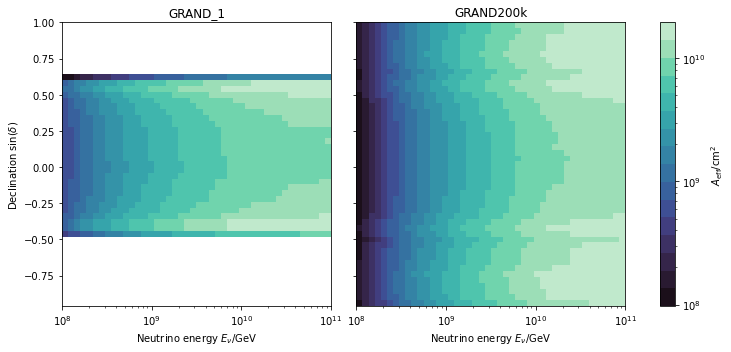

In [58]:
fig, axes=plt.subplots(ncols=2, figsize=(11,5), sharey=True)

ax = axes[0]
ax.set_title('GRAND_1')
p = ax.pcolormesh(
    new_ebins,
    sindec_bins, 
    aeff_i['GRAND_1'].T,
    norm=LogNorm(),
    #vmin=10,
    #vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
#ax.set_xlim(1E2, 1E9)
ax.set_ylabel(r'Declination $\sin(\delta)$')


ax = axes[1]
ax.set_title(r'GRAND200k')
p = ax.pcolormesh(
    new_ebins,
    sindec_bins, 
    aeff_i['GRAND200k'].T,
    norm=LogNorm(),
    #vmin=10,
    #vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
for ax in axes:
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
fig.tight_layout()
cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$A_{\rm eff} / \rm cm^2$')
#ax.set_xlim(1E2, 1E9)
#fig.savefig("../plots/aeff_comparison_IC_PLENUM-1.pdf")

NameError: name 'aeff_i_full' is not defined

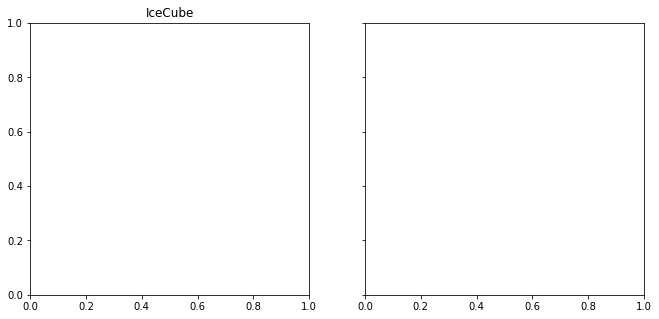

In [29]:
fig, axes=plt.subplots(ncols=2, figsize=(11,5), sharey=True)

ax = axes[0]
ax.set_title('IceCube')
p = ax.pcolormesh(
    new_ebins,
    sindec_bins, 
    aeff_i_full['IceCube'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)
ax.set_ylabel(r'Declination $\sin(\delta)$')


ax = axes[1]
ax.set_title(r'PLE$\nu$M-1')
p = ax.pcolormesh(
    new_ebins,
    sindec_bins, 
    aeff_i_full['Plenum-1'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
for ax in axes:
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
fig.tight_layout()
cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$A_{\rm eff} / \rm cm^2$')
ax.set_xlim(1E2, 1E9)
fig.savefig("../plots/aeff_comparison_IC_PLENUM-1.pdf")

NameError: name 'aeff_i_full' is not defined

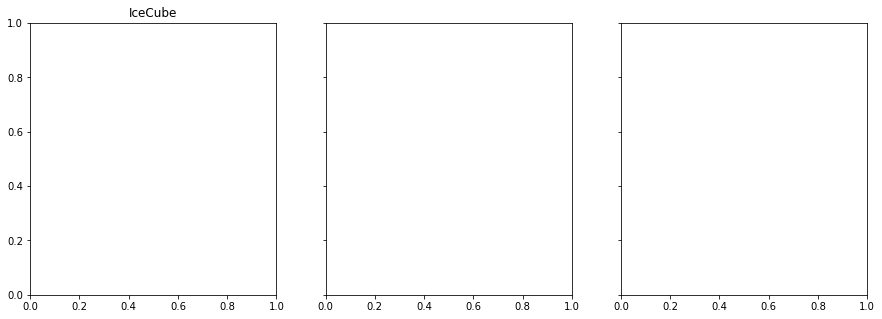

In [30]:
fig, axes=plt.subplots(ncols=3, figsize=(15,5), sharey=True)

ax = axes[0]
ax.set_title('IceCube')
p = ax.pcolormesh(
    new_ebins,
    sindec_bins, 
    aeff_i_full['IceCube'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)
ax.set_ylabel(r'Declination $\sin(\delta)$')

ax = axes[1]
ax.set_title(r'PLE$\nu$M-1')
p = ax.pcolormesh(
    new_ebins,
    sindec_bins, 
    aeff_i_full['Plenum-1'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)

ax = axes[2]
ax.set_title(r'PLE$\nu$M-2')
p = ax.pcolormesh(
    new_ebins,
    sindec_bins, 
    aeff_i_full['Plenum-2'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)

for ax in axes:
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66]) 
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r'$A_{\rm eff} / \rm cm^2$')
fig.subplots_adjust(right=0.88)
fig.savefig("../plots/aeff_comparison_IC_PLENUM-1-2.pdf")

In [31]:
public_data_hist = np.genfromtxt(
    "../icecube_10year_ps/irfs/IC86_II_smearing.csv",
    skip_header=1
)
# #   0                    1                    2                  3                4                 5 
# #  log10(E_nu/GeV)_min  log10(E_nu/GeV)_max  Dec_nu_min[deg]  Dec_nu_max[deg]  log10(E/GeV)_min  log10(E/GeV)_max
# #   6                7            8               9                 10
# #  PSF_min[deg]  PSF_max[deg]  AngErr_min[deg]  AngErr_max[deg]  Fractional_Counts

OSError: ../icecube_10year_ps/irfs/IC86_II_smearing.csv not found.

In [32]:
log_sm_emin, log_sm_emax = public_data_hist[:,0], public_data_hist[:,1]
log_sm_new_emids = (log_sm_emin + log_sm_emax) / 2.

sm_dec_min, sm_dec_max = public_data_hist[:,2], public_data_hist[:,3]
sm_dec_mids = (sm_dec_min + sm_dec_max) / 2.

log_sm_ereco_min, log_sm_ereco_max = public_data_hist[:,4], public_data_hist[:,5]
log_sm_ereco_mids = (log_sm_ereco_min + log_sm_ereco_max) / 2.

log_psf_min, log_psf_max = np.log10(public_data_hist[:,6]), np.log10(public_data_hist[:,7])
log_psf_mids = (log_psf_min + log_psf_max) / 2.

log_sigma_min, log_sigma_max = np.log10(public_data_hist[:,8]), np.log10(public_data_hist[:,9])
log_sigma_mids = (log_sigma_min + log_sigma_max) / 2.

fractional_event_counts = public_data_hist[:,10]

NameError: name 'public_data_hist' is not defined

In [33]:
dec_binning = np.unique(np.concatenate([sm_dec_min, sm_dec_max]))
log_psf_binning = np.linspace(-4.5, 2.5, 25)
ebinning = np.arange(0.5, 9, 0.5)
log_sigma_binning = np.linspace(-0.7, 1.2, 26)

NameError: name 'sm_dec_min' is not defined

## apply PSF smearing
there are three bins in declination